**Goal**
<br> Produce prediction model with the aim of correctly predicting whether or not an ad would have a high click through rate (CTR). A high CTR was defined here as >= 0.08 %. A bid multiplier is then assigned based on whether or not an ad is predicted to have a high CTR.
<br>

**Classifier**
<br> This notebook generates a binary classifier, which, for a given set of features, predicts whether an ad would have a high CTR or a low CTR. 
  - Labels: 
      - High CTR (i.e. >= 0.08 %): class 1
      - Low CTR (i.e < 0.08 %): class 0
  - Features:
      - Device type
      - Time of day (i.e. hour)
      - Day of week

**Evaluation metric** 
<br> The dataset was highly imbalanced with the majority (ca. over 90%) of the observations being in the low CTR class. Correctly predicting that an ad would have a high CTR is more valuable than correctly predicting an ad would have a low CTR. In other words, the cost associated with a false negative is greater than the cost associated with a false positive. 
$$C_{FN} >>  C_{FP}$$
<br> Accordingly, accuracy was not a useful metric, but instead  Recall of the high CTR class was the key metric which the classifier was evaluated on. It should be stated that a high Recall (80 %), came at the expense of a low precision (41 %). 

$$Recall = \frac{TP}{TP + FN}$$   
$$Precision = \frac{TP}{TP + FP}$$

**Cost-sensitive learning**
<br> A weighted RandomForest was used due to its ease of implementation and since promising results of such prediction models for rare event detection have been demonstrated [here](https://www.sciencedirect.com/science/article/pii/S235291482100174X#bib40). To produce the weightings, a cost-sensitive learning approach was taken. This strategy ensures that the classifier does not consider all errors to be equal. For this classifier, different costs were assigned to false negative and false positive events, which were used to produce a cost factor. The cost factor was then used along with the number of observations in both classes to estimate class weightings to be assigned to the classifier. The methodology followed was taken from [here](https://link.springer.com/article/10.1007/s10994-016-5572-x#citeas) (equation 2). Other classifiers should be attempted which employs the cost-sensitive learning e.g. calibrated AdaBoost.

**Results**
- High CTR class: Recall ca. 80%, Precision: 40%
- Low CTR class: Recall ca. 59%, Precision: 91%
- Feature importance order: 
    - Device type 
    - Time of day
    - Day of week
---

### Contents:
1. Import packages and data
2. Functions:
    - Filter data by impression threshold
    - Prepare features and label data
    - Build ML pipeline
    - Evaluate model 
    - Save model
    - Predict CTR for a dataframe of features and produce bid multiplier 
3. Train, evaluate and save classifier
4. Demonstrate use of classifier
   
---

### 1. Import packages and data

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler

from datetime import datetime
import pickle

In [2]:
data = pd.read_csv('../../../../data/data_16_03_22/test_param_performance_formatted.csv')

/home/samara_s/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---

### 2. Functions

In [3]:
def cat_ctr(ctr):
    '''
    For a given ctr, return ctr class based on a set of conditional statements.
    Low CTR : < 0.08 %
    High CTR: >= 0.08 %
    '''
    if ctr < 0.08/100:
        return 0
    else:
        return 1
    
def clean_data(df):
    '''
    Filter dataset to include only observations with impressions >= 1000.
    Add a CTR class column which is based on the CTR column.
    Return dataframe with only the device type, day of week, time of 
    day features and CTR class.
    '''
    
    df_subset = df[['device_type','weekday_user_tz','hour_user_tz','ctr', 'impressions']]
    
    df_1000 = df_subset.loc[df_subset['impressions'] >= 1000]

    df_1000['ctr_class'] = df_1000['ctr'].apply(lambda x:cat_ctr(x))
    
    df_1000.drop(['ctr','impressions'],axis=1, inplace=True)
    
    return df_1000

In [4]:
def prepare_data(data):
    '''
    Clean data and keep the features to be used in the classifier.
    '''
    
    df = clean_data(data)
    
    X = df.drop('ctr_class', axis=1)
    
    y = df['ctr_class'] 
        
    return X, y

In [5]:
def build_model():
    '''
    Data preparation and ML pipeline that onehotencodes all features (categorical), 
    and over samples minority class, undersample samples majority class to reduce class imbalance. 
    RandomForestClassifier parameters were tuned (not included in this notebook) and the prescribed 
    class_weights chosen increased the classifiers ability to correctly detect if a collection of 
    features would result in a high CTR ad. 
    '''
    # intantiate OHE
    categorical_encoder = OneHotEncoder(handle_unknown='ignore')
    
    # List categorical variables in to be OHE
    categorical_columns = ['device_type','weekday_user_tz','hour_user_tz']

    preprocessing = ColumnTransformer(
        [
            ('cat', categorical_encoder, categorical_columns),
        ]
    )

    # intantiate minority class oversampler
    smt = SMOTE()
    
    # intantiate majority class undersampler
    und = RandomUnderSampler()

    # create pipeline
    model = Pipeline(
        [
            ('preprocess', preprocessing),
            ('oversample', smt),
            ('undersample', und),
            ('classifier', RandomForestClassifier(criterion='gini', class_weight={0: 0.37, 1: 0.63}, n_estimators=52, max_features='sqrt'))
        ]
    )

    return model, categorical_columns

In [6]:
def evaluate_model(model, X_test, y_test):
    '''
    Use classifier to predict CTR class of test data and evaluate model
    performance based on recall of CTR class 1. Produce classification 
    report (precision and recall for both classes) and confusion matrix. 
    '''

    y_pred = model.predict(X_test)
    
    target_names = ['Low_CTR:0', 'High_CTR: 1']
    
    accuracy = accuracy_score(y_test, y_pred)
    
    report = classification_report_imbalanced(y_test, y_pred, target_names=target_names)

    print('% Accuracy = {:.2f}'.format(100*accuracy_score(y_test, y_pred)))
    
    print(classification_report_imbalanced(y_test, y_pred, target_names=target_names))
    
    plot_confusion_matrix(model, X_test, y_test)
    
    plt.savefig('conf_mat.png')
    
    return accuracy, report

In [7]:
def plot_performance(model, categorical_columns, X_test, y_test):
    '''
    Plot feature importances and permutation importances.
    '''
    
    ohe = model.named_steps['preprocess'].named_transformers_['cat']
    
    feature_names = ohe.get_feature_names_out(categorical_columns)
    
    tree_feature_importances = model.named_steps['classifier'].feature_importances_

    sorted_idx = tree_feature_importances.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    
    # Plot feature importance
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(8,10))
    ax.barh(y_ticks, tree_feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx], color='black', fontsize=12)
    ax.set_title('RandomForest feature importances', color='black', fontsize=12)
    plt.xticks(color='black', fontsize=12)
    fig.tight_layout()
    plt.show()
    
    result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()

    # Plot permutation importance
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(5,4))
    ax.boxplot(result.importances[sorted_idx].T, vert=True, labels=X_test.columns[sorted_idx], patch_artist=True)
    #ax.set_ylabel('Relative feature importance', color='black', fontsize=12)
    ax.set_ylabel('Permutation feature importance', color='black', fontsize=12)
    plt.xticks(color='black', fontsize=12)
    ax.set_xticklabels(['Day', 'Hour', 'Device type'], color='black', fontsize=12)
    plt.yticks(color='black', fontsize=12)
    fig.tight_layout()
    plt.show()
  

In [8]:
def save_model(model, model_filepath):
    '''
    Export model as a pickle file.
    '''
    
    filename = model_filepath
    with open(filename, 'wb') as f:
        pickle.dump(model, f)        

In [9]:
def gen_bid_multiplier(pred, upper, lower):
    '''
    Set bid multipliers based on predicted CTR class.
    - Class 0 = below target, therefore down-weight bid
    - Class 1 = above target, therefore up-weight bid
    '''
    if pred == 0:    
        return lower
    else:
        return upper
    
def ctr_class_pred(df, model_filepath, csv_filepath):
    '''
    Import trained classifier (model). 
    Use model to onehotencode device_type, day of week and hour features,
    and make prediction of CTR class for each feature set. Add column with 
    CTR class based on device_type, day of week and hour and add another 
    column with bid multiplier depeneding on the ctr_class prediction, if
    class predicted to be high CTR (1), then bid multiplier should be set
    such that the bid if up-weighted and if class predicted to be low CTR (0),
    then bid multiplier should be < 1, so bid would be down-weighted.
    Save dataframe with added ctr_class prediction and bid multiplier column 
    to csv.
    '''
    # Load trained model
    model = pd.read_pickle(model_filepath)
    
    # Use trained model to predict CTR class
    df['predicted_ctr_class'] = model.predict(df)
    
    # Based on CTR class, generate bid multiplier 
    df['bid_multiplier'] = df['predicted_ctr_class'].apply(lambda x:gen_bid_multiplier(x, 1.1, 0.9))
    
    # Save dataframe with predicted CTR class recommeneded bid multiplier as a CSV 
    df.to_csv(csv_filepath)
    
    return df 

## Train, evaluate and save trained classifier
---

In [10]:
# Prepare data using prepare_data function
X, y = prepare_data(data);

# Split data into train and test sets, use stratify parameter to ensure train and test sets include 
# both minority and majority classes are included in the both datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y);

# Train classifier on train data using pipeline created in build_model function
model, categorical_columns = build_model();
model.fit(X_train, y_train);

/tmp/ipykernel_22724/3022735118.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1000['ctr_class'] = df_1000['ctr'].apply(lambda x:cat_ctr(x))
/home/samara_s/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


% Accuracy = 62.89
                   pre       rec       spe        f1       geo       iba       sup

  Low_CTR:0       0.90      0.57      0.82      0.70      0.68      0.45      7695
High_CTR: 1       0.39      0.82      0.57      0.53      0.68      0.47      2584

avg / total       0.77      0.63      0.75      0.65      0.68      0.46     10279



/home/samara_s/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


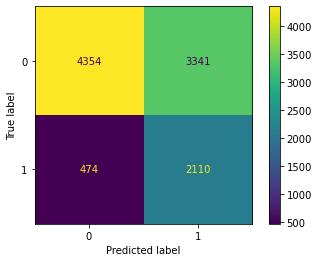

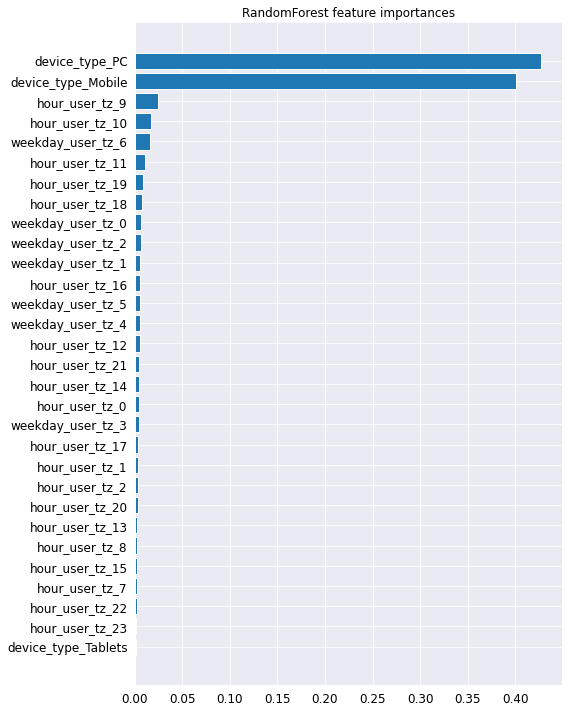

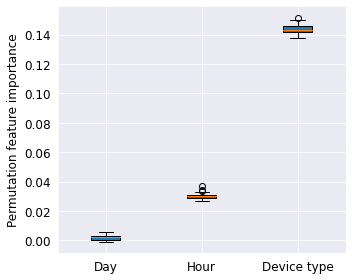

In [11]:
# Print accuracy score, cclassification report, confusion matrix 
accuracy, report = evaluate_model(model, X_test, y_test)

# Produce feature importance and permutation importance plots
plot_performance(model, categorical_columns, X_test, y_test)

# Save trained classifier as a pickle file
save_model(model, '../../../../data/results/classifier_weightedRF.pkl')

---

## Demonstrate use of trained classifier


In [12]:
# Select a sample of the dataset provided keeping only the device_type, day and hour features
test = data[['device_type','weekday_user_tz','hour_user_tz']].sample(1000)

# Use classifier to predict CTR class and produce bid multiplier
df = ctr_class_pred(test, model_filepath='../../../../data/results/classifier_weightedRF.pkl', csv_filepath='../../../../data/results/example_prediction_model_output.csv')

In [13]:
# Preview CTR and bid multiplier
df

,device_type,weekday_user_tz,hour_user_tz,predicted_ctr_class,bid_multiplier
121095,Mobile,2,9,1,1.1
1544934,Mobile,1,8,1,1.1
2490221,Mobile,5,19,1,1.1
3135793,PC,2,2,0,0.9
465425,Mobile,1,23,1,1.1
...,...,...,...,...,...
1443353,Mobile,2,17,1,1.1
3357167,Mobile,5,20,1,1.1
1597997,Mobile,0,2,1,1.1
2198471,PC,0,18,0,0.9
